In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def compare_results(labels, predictions):
    # Create a DataFrame for better visualization
    results_df = pd.DataFrame({
        "Labels": list(labels),
        "Predictions": [f"{p:.1f}" for p in predictions] # Format predictions to one decimal place
    })
    # Transpose the DataFrame for the desired table format (Labels and Predictions as rows)
    results_df = results_df.T

    print("Labels vs Predictions:")
    display(results_df)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [3]:
fetch_housing_data()
housing = load_housing_data()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

C:\Users\pablo\AppData\Local\Temp\ipykernel_32952\3900538190.py:47: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [4]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]

In [5]:
# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [6]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

In [7]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]], shape=(16512, 16))

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# let's try the full preprocessing pipeline on a few training instances
#some_data = housing.iloc[:5]
#some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(housing)
housing_predictions_lin = lin_reg.predict(some_data_prepared)

compare_results(housing_labels, housing_predictions_lin)

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f"Linear Regression RMSE: {lin_rmse:.3f}")

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,85657.9,305492.6,152056.5,186095.7,244550.7,206382.4,376422.1,266569.8,151001.8,30119.5,...,220288.0,83083.1,164708.2,304662.9,159339.2,293885.4,81131.3,220683.2,238863.6,98197.8


Linear Regression RMSE: 68627.874


In [10]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

pd.Series(lin_rmse_scores).describe()

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180657


count       10.000000
mean     69104.079982
std       3036.132517
min      64114.991664
25%      67077.398482
50%      68718.763507
75%      71357.022543
max      73997.080502
dtype: float64

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions_tree = tree_reg.predict(housing_prepared)

compare_results(housing_labels, housing_predictions_tree)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f"Decision Tree Regressor RMSE: {tree_rmse:.3f}")

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0


Decision Tree Regressor RMSE: 0.000


In [12]:
tree_reg_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_reg_scores)
display_scores(tree_rmse_scores)

pd.Series(tree_rmse_scores).describe()

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


count       10.000000
mean     71629.890097
std       3071.663088
min      68960.045444
25%      69602.930320
50%      70525.140962
75%      72753.038693
max      79094.741237
dtype: float64

In [13]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, forest_reg.predict(housing_prepared))

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(f"Random Forest Regressor RMSE: {forest_rmse:.3f}")

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,75324.0,302650.0,82760.0,123227.0,228762.0,159980.0,426397.2,325637.0,185844.0,393656.7,...,237538.0,78550.0,92382.0,322218.0,112884.0,280570.0,95098.0,157736.0,236848.0,73571.0


Random Forest Regressor RMSE: 18650.699


In [14]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

pd.Series(forest_rmse_scores).describe()

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


count       10.000000
mean     50435.580921
std       2322.522327
min      47210.512698
25%      48682.893887
50%      50812.405036
75%      51872.228024
max      54055.908946
dtype: float64

SVR TEST 1:

In [15]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")


Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,169195.1,195754.5,172636.9,170885.1,187808.2,176324.3,200742.4,189397.8,169589.9,155037.7,...,189845.4,164244.5,176249.1,193288.4,171095.1,194315.6,177085.7,175717.4,182928.6,167728.3


Support Vector Machine Regressor RMSE: 111095.066


In [16]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T1 = np.sqrt(-svm_scores)
display_scores(svm_scores_T1)
pd.Series(svm_scores_T1).describe()

Scores: [110518.40356474 112956.5486846  106998.56227015 113590.97575445
 107782.52294955 116063.7781669  113279.08892636 111836.81295967
 113168.96643781 111945.40954593]
Mean: 111814.1069260169
Standard deviation: 2600.840269089257


count        10.000000
mean     111814.106926
std        2741.526360
min      106998.562270
25%      110848.005913
50%      112450.979115
75%      113251.558304
max      116063.778167
dtype: float64

SVR TEST 2:

In [ ]:
svm_reg = SVR(kernel="rbf")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T2 = np.sqrt(-svm_scores)
display_scores(svm_scores_T2)
pd.Series(svm_scores_T2).describe()

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,178735.5,180008.0,178900.9,178924.1,179999.0,179127.4,180409.2,180144.7,178805.4,179064.5,...,179723.3,178497.9,179093.9,180336.6,178896.8,179918.5,179443.5,179218.4,179485.2,178605.7


Support Vector Machine Regressor RMSE: 118578.692
Scores: [116729.13778306 120113.99351281 113925.04340616 120399.11878641
 114687.49942071 122785.64737282 119853.79338279 118280.31108193
 120230.82615529 118840.1885232 ]
Mean: 118584.55594251942
Standard deviation: 2609.6120823493407


count        10.000000
mean     118584.555943
std        2750.772663
min      113925.043406
25%      117116.931108
50%      119346.990953
75%      120201.617995
max      122785.647373
dtype: float64

SVR TEST 3:

In [ ]:
svm_reg = SVR(kernel="poly")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T3 = np.sqrt(-svm_scores)
display_scores(svm_scores_T3)
pd.Series(svm_scores_T3).describe()

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,179159.6,180257.0,179300.4,179189.0,179457.2,179324.4,180019.8,179567.5,179187.4,177927.7,...,179759.6,179141.4,179366.3,179755.7,179146.9,180414.2,178112.5,179212.6,179431.6,178909.4


Support Vector Machine Regressor RMSE: 118429.615
Scores: [116631.48683272 120067.03962509 114120.75279813 120336.06224697
 116047.67419748 122684.28511773 119759.16852962 118396.96066063
 120119.99447634 118794.5082534 ]
Mean: 118695.79327381201
Standard deviation: 2365.2044035633958


count        10.000000
mean     118695.793274
std        2493.144349
min      114120.752798
25%      117072.855290
50%      119276.838392
75%      120106.755764
max      122684.285118
dtype: float64

SVR TEST 4 :

In [17]:
svm_reg = SVR(kernel="sigmoid")
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T4 = np.sqrt(-svm_scores)
display_scores(svm_scores_T4)
pd.Series(svm_scores_T4).describe()

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,178588.4,180778.0,178806.9,178660.9,180180.0,179069.9,181166.2,180241.4,178524.5,177403.4,...,180393.1,178099.9,179124.2,180536.8,178645.4,180624.7,179306.4,178995.1,179698.2,178431.6


Support Vector Machine Regressor RMSE: 118307.022
Scores: [116525.81742693 119872.51263309 113693.66276272 120133.26245924
 114387.29303067 122528.06824174 119620.71627987 118089.09740371
 120005.97239153 118568.46661355]
Mean: 118342.48692430594
Standard deviation: 2610.3388053925028


count        10.000000
mean     118342.486924
std        2751.538697
min      113693.662763
25%      116916.637421
50%      119094.591447
75%      119972.607452
max      122528.068242
dtype: float64

In [18]:
import seaborn as sns

svm_scores_T1.mean
plt.figure(figsize = (8,4))
result_df = pd.DataFrame([svm_scores_T1,svm_scores_T2,svm_scores_T3,svm_scores_T4], ["Linear","RBF","Poly","Sigmoid"],).T
sns.boxplot(data=result_df)
plt.title("Cross validation root mean squared error based on kernel type")
plt.show()

NameError: name 'svm_scores_T2' is not defined

<Figure size 800x400 with 0 Axes>

SVR TEST 1.1

In [19]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear",C= 10000.0)
svm_reg.fit(housing_prepared, housing_labels)

compare_results(housing_labels, svm_reg.predict(housing_prepared))
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Support Vector Machine Regressor RMSE: {svm_rmse:.3f}")

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
svm_scores_T1_1 = np.sqrt(-svm_scores)
display_scores(svm_scores_T1_1)
pd.Series(svm_scores_T1_1).describe()

Labels vs Predictions:


,0,1,2,3,4,5,6,7,8,9,...,16502,16503,16504,16505,16506,16507,16508,16509,16510,16511
Labels,72100.0,279600.0,82700.0,112500.0,238300.0,165700.0,412300.0,349600.0,181300.0,500001.0,...,231300.0,82900.0,96500.0,290800.0,122600.0,268500.0,90400.0,140400.0,258100.0,62700.0
Predictions,77945.8,301541.7,131714.0,174280.5,227838.8,193386.6,369100.9,248779.3,131409.4,36331.2,...,219234.0,76654.8,152278.9,289680.4,142108.2,281292.9,80794.4,205502.0,228686.1,101972.3


Support Vector Machine Regressor RMSE: 70177.777
Scores: [72594.25748433 66077.21607582 67127.38807281 70239.36776881
 67134.74070501 73922.46981932 77137.89459534 70000.3038058
 67545.15000994 70930.05528295]
Mean: 70270.88436201392
Standard deviation: 3333.6185955883902


count       10.000000
mean     70270.884362
std       3513.942537
min      66077.216076
25%      67237.343031
50%      70119.835787
75%      72178.206934
max      77137.894595
dtype: float64

Ploting

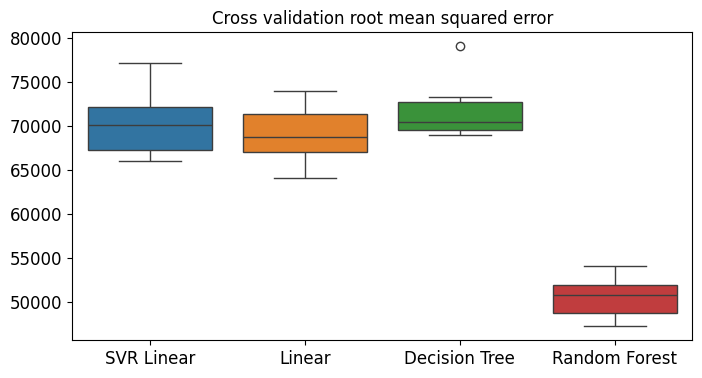

In [20]:
import seaborn as sns
plt.figure(figsize = (8,4))
result_df = pd.DataFrame([svm_scores_T1_1,lin_rmse_scores,tree_rmse_scores,forest_rmse_scores], ["SVR Linear","Linear","Decision Tree","Random Forest"]).T
sns.boxplot(data=result_df)
plt.title("Cross validation root mean squared error")
plt.show()

In [21]:
# Get the describe outputs for each set of scores
describe_T1 = pd.Series(svm_scores_T1_1).describe()
describe_T2 = pd.Series(lin_rmse_scores).describe()
describe_T3 = pd.Series(tree_rmse_scores).describe()
describe_T4 = pd.Series(forest_rmse_scores).describe()

# Combine the describe outputs into a single DataFrame
# Transpose each describe output so stats are rows and kernels are columns
combined_describe = pd.DataFrame({
    "SVM Linear": describe_T1,
    "Linear regression": describe_T2,
    "Decision Tree": describe_T3,
    "Random Forest": describe_T4
})

display(combined_describe)

,SVM Linear,Linear regression,Decision Tree,Random Forest
count,10.000000,10.000000,10.000000,10.000000
mean,70270.884362,69104.079982,71629.890097,50435.580921
std,3513.942537,3036.132517,3071.663088,2322.522327
min,66077.216076,64114.991664,68960.045444,47210.512698
25%,67237.343031,67077.398482,69602.930320,48682.893887
50%,70119.835787,68718.763507,70525.140962,50812.405036
75%,72178.206934,71357.022543,72753.038693,51872.228024
max,77137.894595,73997.080502,79094.741237,54055.908946


In [22]:
from sklearn.model_selection import GridSearchCV

def F_GridSearch(param_grid,regression_algorithm,cv=5):
  grid_search = GridSearchCV(regression_algorithm, param_grid, cv=cv,
                            scoring='neg_mean_squared_error',
                            return_train_score=True, verbose=2)
  grid_search.fit(housing_prepared, housing_labels)
  cvres = grid_search.cv_results_
  for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
  return grid_search

In [ ]:
param_grid_LinearRegressor = [
    {'fit_intercept': [True, False], 'tol': [1e-6, 1e-7, 1e-8], 'positive': [True, False]}
]

Linear_GridSearch = F_GridSearch(param_grid_LinearRegressor,LinearRegression(),5)

In [23]:
param_grid_DecissionTree = [
    {'max_depth': [None, 5, 10, 15, 20]},
    {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [5, 10, 15, 20]},
    {'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_depth': [5, 10, 15, 20]}
]

DecissionTree_GridSearch = F_GridSearch(param_grid_DecissionTree,DecisionTreeRegressor(random_state=42),5)

Fitting 5 folds for each of 53 candidates, totalling 265 fits
[CV] END .....................................max_depth=None; total time=   0.1s
[CV] END .....................................max_depth=None; total time=   0.1s
[CV] END .....................................max_depth=None; total time=   0.1s
[CV] END .....................................max_depth=None; total time=   0.1s
[CV] END .....................................max_depth=None; total time=   0.1s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END ......................................

In [32]:
param_grid_RandomForestRegressor = [
    {'n_estimators': [50,100,150,200], 'max_features': [8,9,10]},
    {'bootstrap': [False], 'n_estimators': [50,100,150,200], 'max_features': [8,9,10]}
  ]

RandomForest_GridSearch = F_GridSearch(param_grid_RandomForestRegressor,RandomForestRegressor(random_state=42),5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ....................max_features=8, n_estimators=50; total time=   3.3s
[CV] END ....................max_features=8, n_estimators=50; total time=   3.3s
[CV] END ....................max_features=8, n_estimators=50; total time=   3.3s
[CV] END ....................max_features=8, n_estimators=50; total time=   3.3s
[CV] END ....................max_features=8, n_estimators=50; total time=   3.5s
[CV] END ...................max_features=8, n_estimators=100; total time=   6.7s
[CV] END ...................max_features=8, n_estimators=100; total time=   6.8s
[CV] END ...................max_features=8, n_estimators=100; total time=   7.0s
[CV] END ...................max_features=8, n_estimators=100; total time=   6.9s
[CV] END ...................max_features=8, n_estimators=100; total time=   6.8s
[CV] END ...................max_features=8, n_estimators=150; total time=  10.1s
[CV] END ...................max_features=8, n_e

In [ ]:
RandomForest_GridSearch.best_estimator_


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,8
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [24]:
param_grid_RVF = [
  {'kernel': ['linear'], 'C': [10.0, 100.0, 1000.0, 10000.0, 20000.0]},
  {'kernel': ['rbf'], 'C': [10.0, 100.0, 1000.0, 10000.0, 20000.0], 'gamma': ['scale', 'auto',0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]
svm_reg = SVR()
RVF_GrindSearch = F_GridSearch(param_grid_RVF,svm_reg,5)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   3.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   3.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   4.1s
[CV] END ..............................C=10.0, kernel=linear; total time=   4.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   3.8s
[CV] END .............................C=100.0, kernel=linear; total time=   3.8s
[CV] END .............................C=100.0, kernel=linear; total time=   3.7s
[CV] END .............................C=100.0, kernel=linear; total time=   3.9s
[CV] END .............................C=100.0, kernel=linear; total time=   3.9s
[CV] END .............................C=100.0, kernel=linear; total time=   3.8s
[CV] END ............................C=1000.0, kernel=linear; total time=   3.9s
[CV] END ............................C=1000.0, 

Now we try with randomized search
Lets star with linear

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, expon, reciprocal

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
Linear_rndSearch = rnd_search.fit(housing_prepared, housing_labels)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Decision tree

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, expon, reciprocal
param_distribs = {
    'max_depth': [None, 5, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

DecisionTree_reg = DecisionTreeRegressor(random_state=42)
rnd_search = RandomizedSearchCV(DecisionTree_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
DecisionTree_rndSearch = rnd_search.fit(housing_prepared, housing_labels)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

66277.72690798008 {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15}
66416.21237368205 {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
66693.21277548163 {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 15}
73421.04358511206 {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
78156.17380739369 {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}
60719.76756146998 {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10}
70959.30270877681 {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
66166.71922375867 {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}
66617.64041765423 {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20}
69938.97503932235 {'min_samples_sp

Random Forest

In [26]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
RandomForest_rndSearch = rnd_search.fit(housing_prepared, housing_labels)

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}
49488.37168451525 {'max_features': 4, 'n_estimators': 158}
49304.50722820199 {'max_features': 6, 'n_estimators': 130}
50556.532150430045 {'max_features': 4, 'n_estimators': 21}
54449.10975813157 {'max_features': 1, 'n_estimators': 58}
49375.34732138837 {'max_features': 6, 'n_estimators': 89}
54450.30065647209 {'max_features': 1, 'n_estimators': 59}
49097.89865126994 {'max_features': 7, 'n_estimators': 170}
49451.2

RVF

In [ ]:
param_distribs = {
        'kernel': ['linear', 'rbf','poly'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
RVF_rndSearch=rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
